In [1]:
import os
import sys
import argparse
import gym
import tensorflow as tf
import numpy as np
import time
import keras
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Activation
from keras.models import Model
from keras.layers.merge import concatenate, Add
from IPython.display import clear_output

sess = tf.InteractiveSession()
keras.backend.set_session(sess)

Using TensorFlow backend.


In [2]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=0.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [3]:
# replay class that stores n size tuple of experiences
class ExpReplay(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size       

    def __len__(self):
        return len(self._storage)

    def add(self, s, a, r, next_s, done):
        data = (s, a, r, next_s, done)
        
        self._storage.append(data)
        storage_size = len(self._storage)
        if (storage_size >= self._maxsize):
            self._storage = self._storage[storage_size-self._maxsize:]
        
    def sample(self, batch_size):
        idx = np.random.randint(0, len(self._storage), size=batch_size)
        batch = np.array(self._storage)[idx]
        states, actions, rewards, next_states, isdone = [], [], [], [], []
        
        for s, a, r, ns, done in batch:
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(ns)
            isdone.append(done)
        
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(isdone)

In [4]:
class Critic:
    def __init__(self, state, action, state_dims, action_dims, scope='critic'):
         
        self.state = state_dims
        self.action = action_dims
        self.state_dims = np.prod(state_dims) 
        self.action_dims = np.prod(action_dims)
        self.scope = scope    
        
        inputs = Input(tensor = state)
        inputs_action = Input(tensor = action)

        x = Dense(400, activation = 'elu')(inputs)
        x_a = Dense(300)(x)
        x_b = Dense(300)(inputs_action)
        out = Add()([x_a, x_b])
        out = Activation('elu')(out)
        self.output = Dense(1)(out)

        self.model = Model(inputs = [inputs, inputs_action], outputs  = self.output)
        self.network_params = self.model.weights
        self.action_grads = tf.gradients(self.model.output, inputs_action)

    def train_step(self, target_Q):
         
        learning_rate = 0.001

        self.optimizer = tf.train.AdamOptimizer(learning_rate)
        self.loss = tf.losses.mean_squared_error(target_Q, self.model.output)
        self.total_loss = self.loss

        train_step = self.optimizer.minimize(self.total_loss, var_list=self.network_params)
        return train_step        

class Actor:
    def __init__(self, state, state_dims, action_dims, action_bound_low, action_bound_high):
         
        self.state = state_dims
        self.state_dims = np.prod(state_dims)  
        self.action_dims = np.prod(action_dims)
        self.action_bound_low = action_bound_low
        self.action_bound_high = action_bound_high
                            
        inputs = Input(tensor = state)
        x = Dense(400, activation = 'relu')(inputs)
        x = Dense(300, activation = 'relu')(x)
        self.output = Dense(self.action_dims,activation = 'tanh')(x)
        self.output = Lambda(lambda i: tf.multiply(
            0.5, tf.multiply(
                i, (self.action_bound_high-self.action_bound_low)) + (self.action_bound_high+self.action_bound_low)))(self.output)

        self.model = Model(inputs = inputs, outputs  = self.output)
        self.network_params = self.model.weights
            
    def train_step(self, action_grads):

        learning_rate = 0.0001

        self.optimizer = tf.train.AdamOptimizer(learning_rate)
        self.grads = tf.gradients(self.model.output, self.network_params, -action_grads)                  
        train_step = self.optimizer.apply_gradients(zip(self.grads, self.network_params))

        return train_step

In [5]:
class DDPG:
    
    def __init__ (
        self,
        env,
        state_dim,
        action_dim,
        action_low,
        action_high,
        replaybuffer,
        warm_steps = 50000,
        tau = 0.001
    ):
        
        self.env = env
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_low = action_low
        self.action_high = action_high
        self.warm_steps = warm_steps
        self.replay = replaybuffer
        self.tau = tau
          
        self.state_ph = tf.placeholder(tf.float32, ((None,) + state_dim))
        self.action_ph = tf.placeholder(tf.float32, ((None,) + action_dim))
        self.target_ph = tf.placeholder(tf.float32, (None, 1))  
        self.action_grads_ph = tf.placeholder(tf.float32, ((None,) + action_dim)) 
        self.is_training_ph = tf.placeholder_with_default(True, shape=None)
            
        self.critic = Critic(self.state_ph, self.action_ph, state_dim, action_dim)
        self.critic_target = Critic(self.state_ph, self.action_ph, state_dim, action_dim)    
            
        self.actor = Actor(self.state_ph, state_dim, action_dim, low, high)
        self.actor_target = Actor(self.state_ph, state_dim, action_dim, low, high)
        
        self.critic_train_step = self.critic.train_step(self.target_ph)
        self.actor_train_step = self.actor.train_step(self.action_grads_ph)
        
        self.update_critic_target = self.update_target_network(self.critic.network_params, self.critic_target.network_params, self.tau)
        self.update_actor_target = self.update_target_network(self.actor.network_params, self.actor_target.network_params, self.tau)
        
    def update_target_network(self, network_params, target_network_params, tau):     
        
        op_holder = []
        for from_var,to_var in zip(network_params, target_network_params):
            op_holder.append(to_var.assign((tf.multiply(from_var, tau) + tf.multiply(to_var, 1. - tau))))        

        return op_holder
        
    def train(self, train_eps = 10000, noise_scale = 0.1):
        
        start_ep = 0
        rewards = []
        sess.run(tf.global_variables_initializer())   
        state = self.env.reset()
        noise_scaling = noise_scale * (self.action_high - self.action_low)
     
        for random_step in range(1, self.warm_steps + 1):
            action = self.env.action_space.sample()
            next_state, reward, done, _ = self.env.step(action)
            self.replay.add(state, action, reward, next_state, done)
            
            state = next_state
            if done:
                state = self.env.reset()
        
        exploration_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(self.action_dim))

        for train_ep in range(start_ep + 1, train_eps + 1):      
            state = self.env.reset()
            
            exploration_noise.reset()
            train_step = 0
            episode_reward = 0
            ep_done = False

            while not ep_done:
                train_step += 1
                start_time = time.time()            

                action = sess.run(self.actor.output, {self.state_ph: state[None]})[0]     
                
                action += exploration_noise() * noise_scaling
                next_state, reward, done, _ = self.env.step(action)
                self.replay.add(state, action, reward, next_state, done)

                episode_reward += reward
                states_batch, actions_batch, rewards_batch, next_states_batch, done_batch = self.replay.sample(64) 

                # Critic training step    
                future_action = sess.run(self.actor_target.output, {self.state_ph: next_states_batch})  
                future_Q = sess.run(self.critic_target.output, {self.state_ph: next_states_batch, self.action_ph: future_action})[:,0]   
                future_Q[done_batch] = 0
                targets = rewards_batch + (future_Q * 0.99)
                sess.run(self.critic_train_step, {self.state_ph:states_batch, self.action_ph:actions_batch, self.target_ph:np.expand_dims(targets, 1)})   

                # Actor training step
                actor_actions = sess.run(self.actor.output, {self.state_ph:states_batch})
                action_grads = sess.run(self.critic.action_grads, {self.state_ph:states_batch, self.action_ph:actor_actions})
                sess.run(self.actor_train_step, {self.state_ph:states_batch, self.action_grads_ph:action_grads[0]})

                # Update target networks
                sess.run(self.update_critic_target)
                sess.run(self.update_actor_target)
                
                state = next_state

                if done or train_step == 1000:
                    rewards.append(episode_reward)
                    clear_output(True)
                    fig = plt.figure(figsize = (12, 7))
                    plt.plot(rewards)
                    plt.show()
                    
                    ep_done = True

        env.close()

In [6]:
import gym
env = gym.make('BipedalWalker-v2')

state_dim = env.observation_space.shape
action_dim = env.action_space.shape
high = env.action_space.high
low = env.action_space.low

replaybuffer = ExpReplay(5e6)
ddpg = DDPG(env, state_dim, action_dim, high, low, replaybuffer)

/home/mkj/.conda/envs/RLsolutions/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


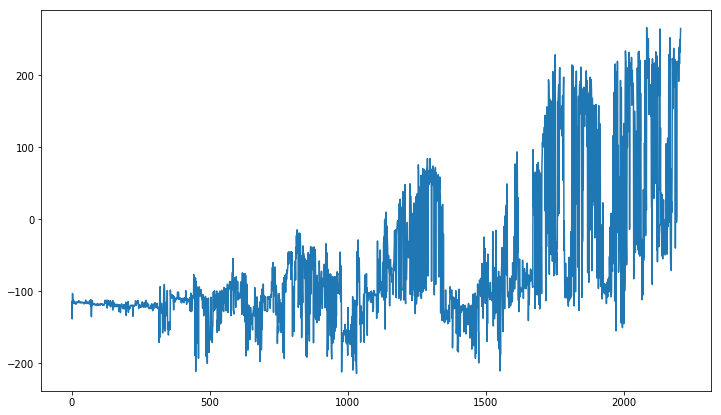

In [ ]:
ddpg.train()

In [ ]:
len(env)